In [1]:
!pip install prophet

In [2]:
# Import required dependencies
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns
from sklearn import tree

In [3]:
#Read in the dataset and import csv file in a DataFrame ("df")
df=pd.read_csv('https://docs.google.com/spreadsheets/d/1_ODNIn5n1k9RSVr_7gV2On4idZ6v0B2XPeMhCD18kio/pub?gid=1188863554&single=true&output=csv')
    #df.head()

# create a new "cheif_term" column and add to the "df" DataFrame
chiefs = df['chief'].unique()
x = 0
for chief in chiefs:
    #print(chief)
    df.loc[df['chief'] == chief, 'chief_term'] = x
    #dfcoyp['chief_term'] = x
    x = x + 1

# print preview of "df" DataFrame
df.head()

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,...,authorityDecision2,lawType,lawSupp,lawMinor,majOpinWriter,majOpinAssigner,splitVote,majVotes,minVotes,chief_term
0,2021-036,2021-036-01,2021-036-01-01,2021-036-01-01-01,1/13/2022,6,NaN,142 S. Ct. 647,211 L. Ed. 2d 433,2022 U.S. LEXIS 495,...,NaN,3.0,309.0,NaN,NaN,111.0,1,5,4,0.0
1,2021-036,2021-036-01,2021-036-01-01,2021-036-01-01-01,1/13/2022,6,NaN,142 S. Ct. 647,211 L. Ed. 2d 433,2022 U.S. LEXIS 495,...,NaN,3.0,309.0,NaN,NaN,111.0,1,5,4,0.0
2,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01,11/18/1946,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,NaN,6.0,600.0,35 U.S.C. ¤ 33,78.0,78.0,1,8,1,1.0
3,1946-002,1946-002-01,1946-002-01-01,1946-002-01-01-01,11/18/1946,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,...,NaN,6.0,600.0,18 U.S.C. ¤ 398,81.0,87.0,1,6,3,1.0
4,1946-002,1946-002-02,1946-002-02-01,1946-002-02-01-01,11/18/1946,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,...,NaN,6.0,600.0,18 U.S.C. ¤ 398,81.0,87.0,1,6,3,1.0


In [4]:
# Review data types and shape of "df"
print(f'Data Types: \n{df.dtypes}\n\n DataFrame Shape: {df.shape}')

Data Types: 
caseId                       object
docketId                     object
caseIssuesId                 object
voteId                       object
dateDecision                 object
decisionType                  int64
usCite                       object
sctCite                      object
ledCite                      object
lexisCite                    object
term                          int64
naturalCourt                  int64
chief                        object
docket                       object
caseName                     object
dateArgument                 object
dateRearg                    object
petitioner                  float64
petitionerState             float64
respondent                  float64
respondentState             float64
jurisdiction                float64
adminAction                 float64
adminActionState            float64
threeJudgeFdc               float64
caseOrigin                  float64
caseOriginState             float64
caseSource     

In [5]:
#change decision date to DT for data exploration
df['dateDecision'] = pd.to_datetime(df['dateDecision'], errors='coerce')

In [6]:
#create a year column for easier sorting and aggregation in visualizations
df['yearDecision'] = df['dateDecision'].dt.year

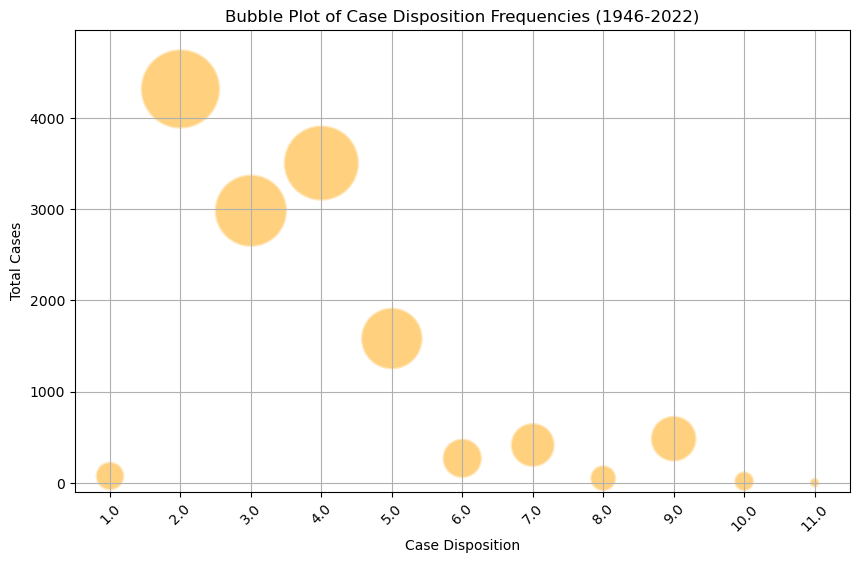

In [7]:
# Exploration Question #1: What is the most common caseDisposition? 

# Visualize the most frequest caseDisposition over total data set (not just by year) using a Bubble Plot

# Filter the DataFrame by Case Disposition and create a count column for a total count of each CD classes
case_disposition_counts = df['caseDisposition'].value_counts()
case_disposition_counts_df = pd.DataFrame(case_disposition_counts).reset_index()

# Create the bubble plot

# Create components of bubble plot (normalize bubble size for better viewing)
case_disposition_classes = case_disposition_counts_df['caseDisposition']
volume_of_cases = case_disposition_counts_df['count']
bubble_size = bubble_sizes = np.sqrt(volume_of_cases)  * 50

plt.figure(figsize=(10, 6))
plt.scatter(
    case_disposition_classes, 
    volume_of_cases,
    s = bubble_size,  
    alpha=0.5,  
    c='orange',  
    edgecolors='w',  
    linewidth=2  
)
# Set the title and labels
plt.title('Bubble Plot of Case Disposition Frequencies (1946-2022)')
plt.xlabel('Case Disposition')
plt.ylabel('Total Cases')

#Fix x-axis display and use caseDisposition values as tick positions
x_ticks = case_disposition_classes
plt.xticks(ticks=x_ticks, labels=x_ticks, rotation=45)  # Rotate labels if needed for readability

#Fix y-axis dispaly to view whole bubble (set a little below zero and 15% above maximum)
plt.ylim(-100, max(volume_of_cases) * 1.15)  

#save the plot to outputs folder

plt.savefig('outputs/case_disposition_bubble_plot.png')
# Show the plot
plt.grid(True)
plt.show()

In [8]:
# Exploration Question #2: Have case dispositions changed over time?

# Determine the most frequent Case Disposition Classification by Year
# Filter the DataFrame by Year and Case Disposition and create a mode column for most frequent classification of CD
# Apply function to account for multiple modes (select first) and no mode (fill with NaN)
case_disposition_mode = df.groupby('yearDecision')['caseDisposition'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
case_disposition_mode_df = pd.DataFrame(case_disposition_mode)
# reset the index and preview
case_disposition_mode_df = case_disposition_mode_df.reset_index()
case_disposition_mode_df.head()

,yearDecision,caseDisposition
0,1946,2.0
1,1947,2.0
2,1948,2.0
3,1949,2.0
4,1950,2.0


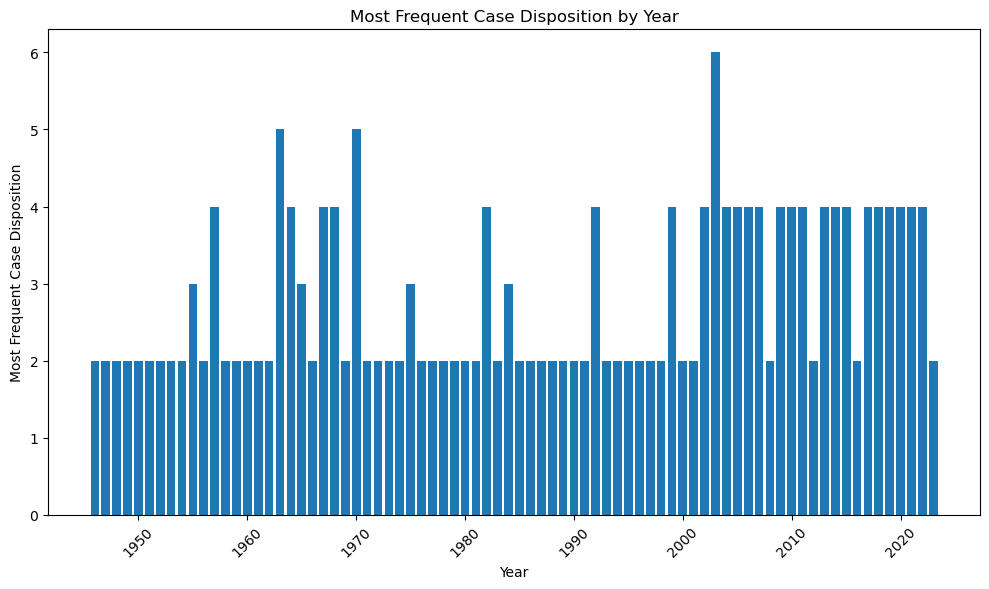

In [9]:
# visualize the mode by year with a bar graph and save image to outputs file
plt.figure(figsize=(10, 6)) 
plt.bar(case_disposition_mode_df['yearDecision'], case_disposition_mode_df['caseDisposition'])
# add labels
plt.xlabel('Year')  
plt.ylabel('Most Frequent Case Disposition') 
plt.title('Most Frequent Case Disposition by Year') 
# format to improve readability of x-axis and graph

plt.xticks(rotation=45)  
plt.tight_layout()  

plt.savefig('outputs/case_disposition_by_year.png')
plt.show()

In [10]:
# Exploration Question #3: How have case dispositions changed over time, based on who is serving as Chief Justice?
# Filter the DataFrame by Term of Chief Justice and Case Disposition
chief_counts = df.groupby(['chief'])['caseDisposition'].value_counts()
chief_counts_df = pd.DataFrame(chief_counts)
chief_counts_df.head()

count
chief  caseDisposition       
Burger 2.0               1257
       3.0               1048
       4.0               1005
       5.0                506
       7.0                134

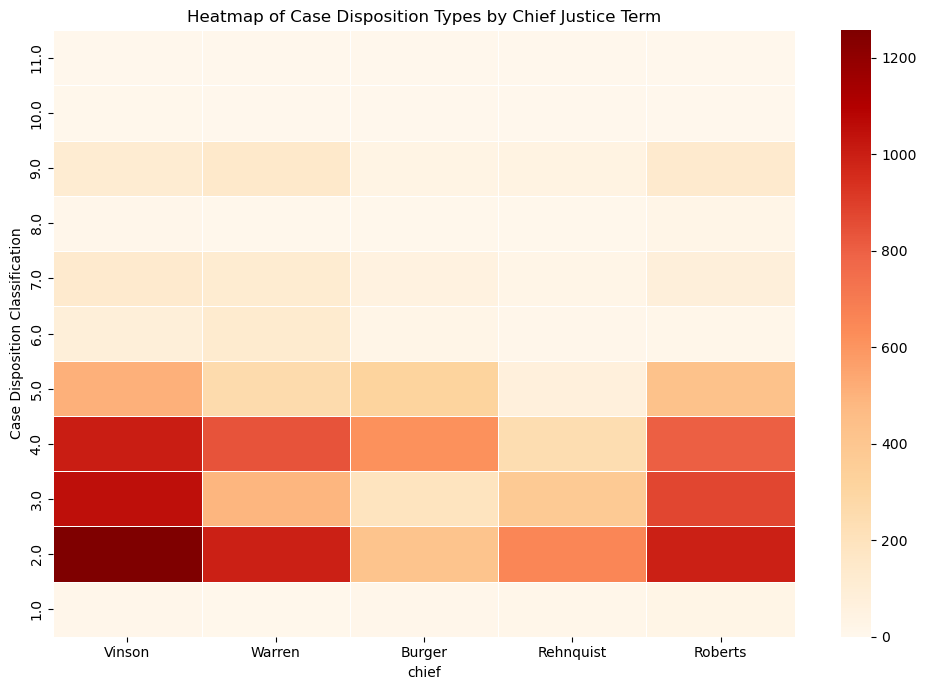

In [11]:
# Create a pivot table for plotting
pivot_df2 = chief_counts_df.pivot_table(index='caseDisposition', columns=['chief'], values='count', fill_value=0)

# Fix index for display purposes
pivot_df2 = pivot_df2.sort_index(ascending=False)

# Plot the heatmap
plt.figure(figsize=(10, 7))
ax1 = sns.heatmap(pivot_df2, annot=False, cmap='OrRd', cbar=True, linewidths=.5)

# Add labels and format
plt.title('Heatmap of Case Disposition Types by Chief Justice Term')
ax1.set_xticklabels(['Vinson', 'Warren', 'Burger', 'Rehnquist', 'Roberts'] * (pivot_df2.shape[1] // 5))
plt.ylabel('Case Disposition Classification')
plt.tight_layout()  
# Save the plot
plt.savefig('outputs/heatmap_cd_cjterm.png')
# Show the heatmap plot
plt.show()

In [12]:
#Exploration Question #4: Can we categorize the overall tone of case decisions based on the term of the chief justice?
# Filter the DataFrame by Term of Chief Justice and Decision Direction and add a count column for DD classes
chief_counts_dd = df.groupby(['chief_term', 'chief'])['decisionDirection'].value_counts()
chief_counts_dd_df = pd.DataFrame(chief_counts_dd)
chief_counts_dd_df.head()

count
chief_term chief   decisionDirection       
0.0        Roberts 1.0                  871
                   2.0                  777
                   3.0                   36
1.0        Vinson  1.0                  732
                   2.0                  669

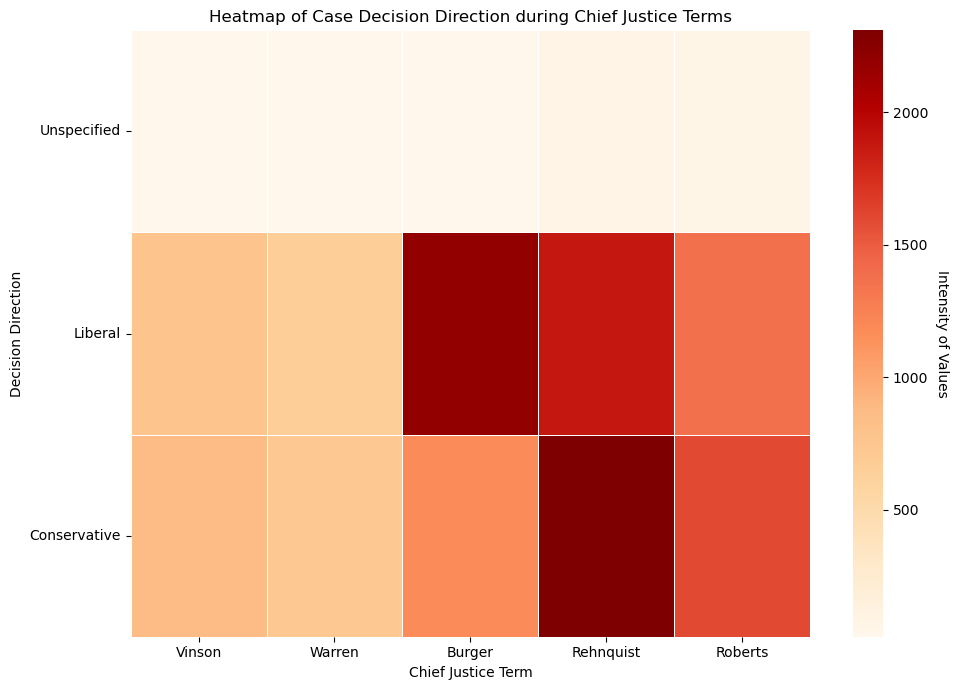

In [13]:
# Pivot the DataFrame to get counts for each direction per term
pivot_dd_index = chief_counts_dd_df.pivot_table(index='decisionDirection', columns='chief_term', values='count', fill_value=0)
pivot_dd = pivot_dd_index.sort_index(ascending=False)

# Plot the heatmap and save as a variable for customization
plt.figure(figsize=(10, 7))
ax = sns.heatmap(pivot_dd, cmap="OrRd", cbar=True, linewidths=.5)

# Center x-tick and y-tick in middle (rather than at classification's numerical position)
ax.set_xticks(np.arange(pivot_dd.shape[1]) + 0.5)
ax.set_yticks(np.arange(pivot_dd.shape[0]) + 0.5)

# Change x-tick and y-tick labels from numerical classification to corresponding text value and format 
ax.set_xticklabels(['Vinson', 'Warren', 'Burger', 'Rehnquist', 'Roberts'] * (pivot_dd.shape[1] // 5))
ax.set_yticklabels(["Unspecified", "Liberal", "Conservative"], rotation=0)

# Customize the color bar (legend)
colorbar = ax.collections[0].colorbar
colorbar.set_label('Intensity of Values', rotation=270, labelpad=15)

# Customize the plot
plt.title('Heatmap of Case Decision Direction during Chief Justice Terms')
plt.xlabel('Chief Justice Term')
plt.ylabel('Decision Direction')
plt.tight_layout()  # Adjust layout to fit labels
#save the plot
plt.savefig('outputs/heatmap_dd_cjterm.png')
# Show the plot
plt.show()

In [14]:
#Exploration Question #5: Can we predict the overall tone of future decisions?
#creating dataframe for using in projection modeling
dd_by_date_df = pd.DataFrame(df[['dateDecision','decisionDirection']])
dd_by_date_df.tail()

,dateDecision,decisionDirection
13851,2023-06-22,2.0
13852,2023-06-22,2.0
13853,2023-05-25,1.0
13854,2023-05-22,1.0
13855,2023-06-23,1.0


In [15]:
#change columns names for dd Dataframe for projections
dd_by_date_df.columns = ["ds", "y"]
dd_by_date_df.tail()

,ds,y
13851,2023-06-22,2.0
13852,2023-06-22,2.0
13853,2023-05-25,1.0
13854,2023-05-22,1.0
13855,2023-06-23,1.0


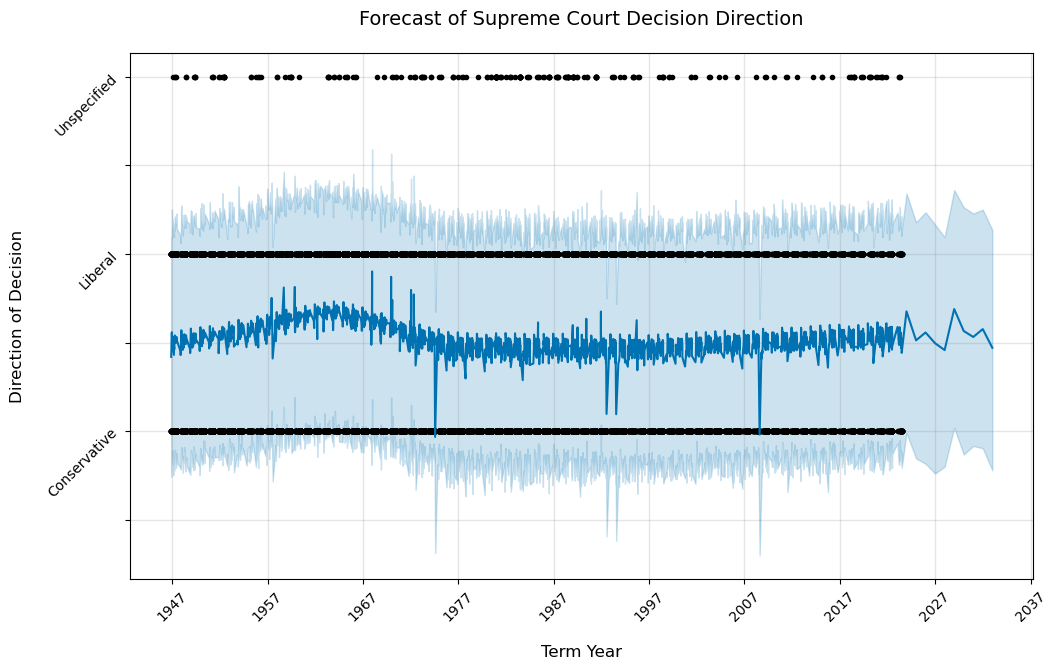

In [16]:
#creating variables forecasting period and frequency (years)
forecasting_period = 10
forecasting_frequency = 'Y'

# Create a Prophet model
model = Prophet()

# Fit the model to the data
model.fit(dd_by_date_df)

# Create a future dataframe for prediction
future = model.make_future_dataframe(periods=forecasting_period, freq=forecasting_frequency)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)

# FORMAT AXES

# Access the axes
ax = fig.gca()

# Label x-axis, y-axis, and titles
ax.set_xlabel('Term Year', fontsize=12, labelpad=15)  
ax.set_ylabel('Direction of Decision', fontsize=12, labelpad=15)
ax.set_title('Forecast of Supreme Court Decision Direction', fontsize=14, pad=20)  # Set plot title

# Label x-ticks and y-ticks
ax.tick_params(axis='x', rotation=45)  

ax.tick_params(axis='y', labelsize=10) 
new_labels = [' ', ' ', 'Conservative', '', 'Liberal', '', 'Unspecified']
ax.set_yticklabels(new_labels, rotation=45, fontsize=10)

# save the plot
plt.savefig('outputs/forecast_dd.png')
clear_output()
# Show the plot
plt.show()

c:\Users\dipes\anaconda_3\envs\dev1\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\dipes\anaconda_3\envs\dev1\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\dipes\anaconda_3\envs\dev1\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

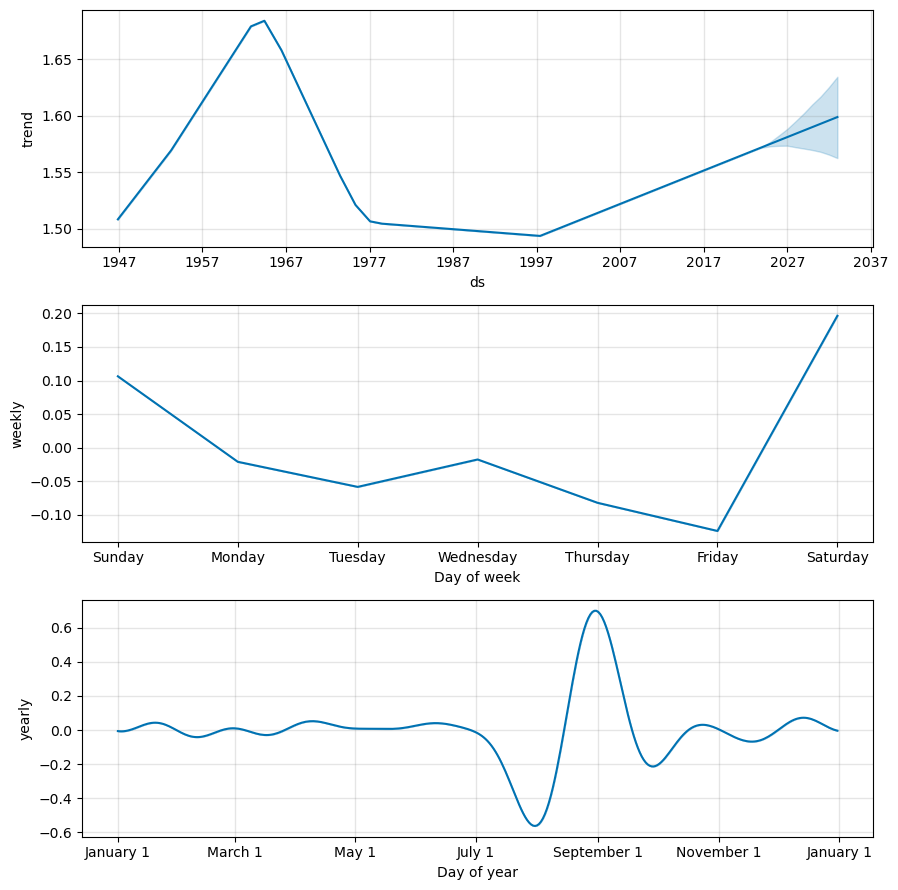

In [17]:
# plot the components
fig = model.plot_components(forecast)
# save the component plot
plt.savefig('outputs/forecast_dd_components.png')
# Show the plot
clear_output()
plt.show()

In [18]:
#Create a new working DataFrame from original "df" called "dfwork" with reduced columns
dfwork = df[[
#"issueArea",
"decisionDirection",
"decisionType",
"threeJudgeFdc",
"certReason",
#"lcDisposition",
"lcDispositionDirection",
"partyWinning",
"majVotes",
"chief_term",
"minVotes",
"caseDisposition"
]]

In [19]:
# Create a correlation table to view relationship between variables
corr_df = dfwork.corr()
# save correlation csv to outputs file
corr_df.to_csv('outputs/correlation.csv', index=False)
corr_df

,decisionDirection,decisionType,threeJudgeFdc,certReason,lcDispositionDirection,partyWinning,majVotes,chief_term,minVotes,caseDisposition
decisionDirection,1.000000,-0.010765,0.005252,-0.040552,-0.108344,0.094870,0.107677,-0.035575,-0.121187,-0.027196
decisionType,-0.010765,1.000000,0.016747,0.059465,-0.056137,-0.067098,-0.059918,-0.009194,0.049004,0.176046
threeJudgeFdc,0.005252,0.016747,1.000000,-0.396596,0.110345,-0.015413,-0.026777,0.026729,0.029542,0.010968
certReason,-0.040552,0.059465,-0.396596,1.000000,-0.091418,0.098213,-0.032774,-0.068232,0.022651,0.055668
lcDispositionDirection,-0.108344,-0.056137,0.110345,-0.091418,1.000000,0.008546,-0.036939,0.094245,0.052484,-0.034644
partyWinning,0.094870,-0.067098,-0.015413,0.098213,0.008546,1.000000,0.094190,-0.027027,-0.092977,0.296390
majVotes,0.107677,-0.059918,-0.026777,-0.032774,-0.036939,0.094190,1.000000,0.009989,-0.931425,0.109203
chief_term,-0.035575,-0.009194,0.026729,-0.068232,0.094245,-0.027027,0.009989,1.000000,0.017381,0.020606
minVotes,-0.121187,0.049004,0.029542,0.022651,0.052484,-0.092977,-0.931425,0.017381,1.000000,-0.110067
caseDisposition,-0.027196,0.176046,0.010968,0.055668,-0.034644,0.296390,0.109203,0.020606,-0.110067,1.000000


In [20]:
#creating prompts to use for user inouts
prompts=pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTcUMWXktcB48qH6B77aGPX1XfrkbBc2_RxzJbmCdtDkUZa2m1orezx1pcrGdvfGytfNQL8L-_58SyP/pub?gid=0&single=true&output=csv")
prompts = prompts.sort_values(by = ['features', 'selection'])
prompts.reset_index(drop=True, inplace=True)
starting_with_0 = ['partyWinning','threeJudgeFdc']
prompts_0 = prompts[prompts['features'].isin(starting_with_0)]
prompts_1 = prompts[~prompts['features'].isin(starting_with_0)]

In [39]:
model_score = []
target = None

# creating functions for use in runnin models and predictions

def run_model(target): # executing model by passing a target column
    #creating dfwork to use for training and testing models
    dfwork = df[[
    #"issueArea",
    "decisionDirection",
    "decisionType",
    "threeJudgeFdc",
    "certReason",
    #"lcDisposition",
    "lcDispositionDirection",
    "partyWinning",
    "majVotes",
    "chief_term",
    "minVotes",
    "caseDisposition"
    ]]

    #passing target column to y
    y=df[[target]]
    
    #dropping y from dfwork to get X
    X = dfwork.drop(columns=y)
    
    #reseting index
    dfwork= dfwork.sort_index(axis=1)
    
    #creating list to move columns to set the correct order
    columns_to_move = ['majVotes', 'minVotes']
    
    #reatining all other columns
    remaining_columns = [col for col in dfwork.columns if col not in columns_to_move]
    
    #recreating dfwork with tow columns moved to end.
    dfwork = dfwork[remaining_columns + columns_to_move]

    # Impute missing values with constant values
    imputery = SimpleImputer(strategy='constant', fill_value=0)
    
    #reshaping y for use in testing and training
    y_imputed = imputery.fit_transform(y).reshape(-1)
    
    # Imputing missing values with most frequeent X values
    imputerx = SimpleImputer(strategy='most_frequent')
    
    X_imputed = pd.DataFrame(imputerx.fit_transform(X), columns=X.columns)
    
    #creating training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, random_state=42)
    
    #returning training and testing sets along with target column
    return X_train, X_test, y_train, y_test, target

#creating function to modesl using data returned by run_model function
def models(X_train, X_test, y_train, y_test, target):
    
    print(f"target column: {target}")
    print(f"Training K Neighbors Classifier model")
    #calling knn function to run K Neighbors Classifier Model
    knn(X_train, X_test, y_train, y_test, target)
    
    
    print(f"Training Logistics Regression Model")
    #calling lr function to run Logistics Regression Model
    lr(X_train, X_test, y_train, y_test, target)
    
    
    print(f"Training Random Forest Classifier Model")
    #calling rf function to run Random Forest Classifer Model
    rf(X_train, X_test, y_train, y_test, target)
    
    
    print(f"Training Decision Tree Classifier Model")
    #calling dt function to run Decision Tree classifer model
    dt(X_train, X_test, y_train, y_test, target)
    print("Taking up next target column")

# creating K Neighbors Classifier classifeir model
def knn(X, xt,y, yt, target):
    
    #initializing model
    model = KNeighborsClassifier(n_neighbors=10)
    
    #model_name to pass to to model score array
    model_name = 'KNN'
    
    #function_name to pass to to model score array
    function_name = 'knn'
    
    # Fit the model to the training data
    model.fit(X, y)

    #using score function to create training score to add in score summary
    train_score = model.score(X, y)
    
    #using score function to create testing score to add in score summary
    test_score = model.score(xt, yt)
    
    #assigning predictions
    predictions = model.predict(xt)
    
    #checking accuracy score
    acc_score = accuracy_score(yt, predictions)
    
    #running updae score function to write variable to an array
    update_score(target,model_name, function_name, train_score, test_score, acc_score)
    
    return model # returns trained model

def lr(X, xt,y, yt, target):
    #initializing logistic regression classifier model
    model = LogisticRegression(max_iter=2500)

    #model_name to pass to to model score array
    model_name = 'Logistic Regression'

    #function_name to pass to to model score array
    function_name = 'lr'

    # Fit the model to the training data
    model.fit(X, y)

    #using score function to create training score to add in score summary
    train_score = model.score(X, y)
    
    #using score function to create testing score to add in score summary
    test_score = model.score(xt, yt)
    
    #assigning predictions
    predictions = model.predict(xt)
    
    #checking accuracy score
    acc_score = accuracy_score(yt, predictions)
    
    #running updae score function to write variable to an array
    update_score(target,model_name, function_name, train_score, test_score, acc_score)
    
    return model # returns trained model

def rf(X, xt,y, yt, target):
    
    #initializing model
    model = RandomForestClassifier(n_estimators=128, random_state=42)
    
    #model_name to pass to to model score array
    model_name = 'Random Forest'
    
    #function_name to pass to to model score array
    function_name = 'rf'
    
    # Fit the model to the training data
    model.fit(X, y)

    #using score function to create training score to add in score summary
    train_score = model.score(X, y)
    
    #using score function to create testing score to add in score summary
    test_score = model.score(xt, yt)
    
    #assigning predictions
    predictions = model.predict(xt)
    
    #checking accuracy score
    acc_score = accuracy_score(yt, predictions)
    
    #running updae score function to write variable to an array
    update_score(target,model_name, function_name, train_score, test_score, acc_score)
    
    return model # returns trained model

def dt(X, xt,y, yt, target):
    
    #Initializing model
    model = tree.DecisionTreeClassifier()
    
    #model_name to pass to to model score array
    model_name = 'Decision Tree'
    
    #function_name to pass to to model score array
    function_name = 'dt'

    # Fit the model to the training data
    model.fit(X, y)

    #using score function to create training score to add in score summary
    train_score = model.score(X, y)
    
    #using score function to create testing score to add in score summary
    test_score = model.score(xt, yt)
    
    #assigning predictions
    predictions = model.predict(xt)
    
    #checking accuracy score
    acc_score = accuracy_score(yt, predictions)
    
    #running updae score function to write variable to an array
    update_score(target,model_name, function_name, train_score, test_score, acc_score)
    
    return model # returns trained model

#fucnton to create model_score array
def update_score(target, model, fn, trs, tss, acc):
    #appending model_score values fro each model run
    model_score.append({'target_column': target, 'model_name': model, 'function_name' : fn, 'training_score': trs, 'testing_score': tss, 'accuracy_score': acc})
    
# function o create prompts for user and generating predictions
def predict_outcome(trained_model):

    #initializing selection1 as a numpy array    
    selection1 = np.array([])

    #creating dataframe for all prompts starting with 1
    p1s = prompts_1[prompts_1['features']!=target]
    #creating dataframe for all prompts starting with 0
    p0s = prompts_0[prompts_0['features']!=target]

    # running a for loop for all prompts within p1s
    for p1 in p1s['features'].unique():
        
        display(f"Please select a feature from the list of {p1} below:")
        
        #generating list of prompts where inputs start with 1
        for i, feature in enumerate((p1s[p1s['features'] == p1]['value']), start=1):
            display(f"{i}... {feature}")
        
        #appending selection to selection array
        selection1 = np.append(selection1,int(input("Enter the number corresponding to your choice: "))).astype(int)
        
        #clearing output for next inputs
        clear_output()

    # running a for loop for all prompts within p1s
    for p0 in p0s['features'].unique():
        #time.sleep(1)

        display(f"Please select a feature from the list of {p0} below:")
        
        #generating list of prompts where inputs start with 0
        for i, feature in enumerate((p0s[p0s['features'] == p0]['value']), start=0):
            display(f"{i}... {feature}")
        
        #appending selection to selection array
        selection1 = np.append(selection1,int(input("Enter the number corresponding to your choice: "))).astype(int)
        
    #clearing output for next inputs
        clear_output()
        
    #appending inputs for majority votes to selection1
    selection1 = np.append(selection1,int(input("Enter number of majority votes: "))).astype(int)
    
    #appending inputs for minority votes to selection1
    selection1 = np.append(selection1,int(input("Enter number of minority votes: "))).astype(int)
    
    #creating dataframe from numpy array
    selection_df = pd.DataFrame(selection1)
    
    #transforming the frame
    selection_df = selection_df.T
    
    
    #selection_df.loc[0]
    
    #creating an integer based array from float based array
    X_new1 = np.array([selection_df.iloc[0].to_numpy().astype(int)])
    
    ##assigning prediction value user inputs to the trained model
    prediction = trained_model.predict(X_new1)
    
    #looking up feature name from prompts datafram by filtering daraframe on features and description of predicted value
    feature_name = prompts[(prompts['features'] == target) & (prompts['selection'] == round(prediction[0]))]['feature_name'].iloc[0]
    
    #looking up the prompt name aka result from prompts datafram by filtering daraframe on features and description of predicted value
    my_prediction = prompts[(prompts['features'] == target) & (prompts['selection'] == round(prediction[0]))]['value'].iloc[0]
    
    #clearing output on the screen
    clear_output()

    #printing final result
    print(f"Based on my training and analysis of inputs, I predict that outcome of {feature_name} will be : {my_prediction}")

In [40]:
#creating list of target columns to check which will give us best performance
targets = ('partyWinning', 'decisionDirection', 'decisionType', 'caseDisposition')

#initializing model_score to ensure it is emptied out
model_score = []

# looping through each columns defined in targets
for target in targets:

    #cresting training and testing sets using run model fucntion by passing each value from targets
    X_train, X_test, y_train, y_test, target = run_model(target)
    
    #Running all the models defined under models function
    models(X_train, X_test, y_train, y_test, target)
    
    clear_output()
#creating and displaying model_scores dataframe
model_scores = pd.DataFrame(model_score)

#clear_output()

model_scores

,target_column,model_name,function_name,training_score,testing_score,accuracy_score
0,partyWinning,KNN,knn,0.957564,0.954965,0.954965
1,partyWinning,Logistic Regression,lr,0.781370,0.786085,0.786085
2,partyWinning,Random Forest,rf,0.990666,0.976039,0.976039
3,partyWinning,Decision Tree,dt,0.990666,0.970266,0.970266
4,decisionDirection,KNN,knn,0.892513,0.878464,0.878464
5,decisionDirection,Logistic Regression,lr,0.625866,0.622691,0.622691
6,decisionDirection,Random Forest,rf,0.951212,0.925808,0.925808
7,decisionDirection,Decision Tree,dt,0.951309,0.917148,0.917148
8,decisionType,KNN,knn,0.858064,0.850173,0.850173
9,decisionType,Logistic Regression,lr,0.831024,0.839781,0.839781


In [25]:
#printing the best permforming model and target column by looking up from max score
print(f"Best target column / model is: "
      f"{model_scores[model_scores['accuracy_score'] == model_scores['accuracy_score'].max()]['target_column'].iloc[0]} / "
      f"{model_scores[model_scores['accuracy_score'] == model_scores['accuracy_score'].max()]['model_name'].iloc[0]}")

Best target column / model is: partyWinning / Random Forest


In [26]:
#creating csv file for output
model_scores.to_csv('scores.csv', index=False)

In [27]:

# pulling data from csv file for creating prompts for user inputs and other uses
prompts=pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTcUMWXktcB48qH6B77aGPX1XfrkbBc2_RxzJbmCdtDkUZa2m1orezx1pcrGdvfGytfNQL8L-_58SyP/pub?gid=0&single=true&output=csv")

#sorting data by feature and selection columns
prompts = prompts.sort_values(by = ['features', 'selection'])

#resetting index
prompts.reset_index(drop=True, inplace=True)

In [28]:
#initializing trained model vaiable
trained_model = None

#The modesl have been trained on partyWinning, decisionDirection, decisionType, caseDisposition
target = 'decisionType'

#Initializing training and testing sets and target column for fitting and predicting using a model
Xn, Xt, yn, yt, tgt = run_model(target)

#sending datasets and target column to get prediction
predicted_result = rf(Xn, Xt, yn, yt, tgt)

#getting prediction text by matching in prompts dataframe
predict_outcome(predicted_result)

Based on my training and analysis of inputs, I predict that outcome of decision type will be : opinion of the court (orally argued)
